<a href="https://colab.research.google.com/github/antonellagambarte/vision-por-computadoras-II/blob/main/Copia_de_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook para baseline

In [1]:
import gdown
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import random
import cv2
import numpy as np
import hashlib

In [2]:
url = "https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk"
output = "archivo.zip"

gdown.download(url, output, quiet=False, fuzzy=True)

destino = "datos_zip"
os.makedirs(destino, exist_ok=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(destino)

print("Archivo extraído correctamente en :", destino)

Downloading...
From (original): https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk
From (redirected): https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk&confirm=t&uuid=180f144e-713a-43ce-a6f8-5fac79358c6d
To: /content/archivo.zip
100%|██████████| 2.19G/2.19G [00:30<00:00, 71.9MB/s]


Archivo extraído correctamente en : datos_zip


In [3]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import time
import torchsummary

In [4]:
data_dir = "datos_zip/plantvillage dataset/color"

full_dataset = datasets.ImageFolder(root=data_dir)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [5]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                  [0.229, 0.224, 0.225])
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                  [0.229, 0.224, 0.225])
])


In [6]:
train_dataset.dataset.transform = train_tfms
test_dataset.dataset.transform = test_tfms

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
from torchvision.models import MobileNet_V2_Weights
list(MobileNet_V2_Weights)

[MobileNet_V2_Weights.IMAGENET1K_V1, MobileNet_V2_Weights.IMAGENET1K_V2]

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_classes = len(full_dataset.classes)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.last_channel, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 122MB/s]


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
torchsummary.summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [12]:
epochs = 3

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # --------------------------
    #   TRAIN
    # --------------------------
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)


    # --------------------------
    #   VALIDATION
    # --------------------------
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(test_loader)
    epoch_val_acc = 100 * correct / total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.2f}%")


Epoch 1/3 | Train Loss: 1.9497 | Val Loss: 1.0693 | Val Acc: 84.40%
Epoch 2/3 | Train Loss: 0.8578 | Val Loss: 0.6092 | Val Acc: 90.41%
Epoch 3/3 | Train Loss: 0.5653 | Val Loss: 0.4245 | Val Acc: 92.54%


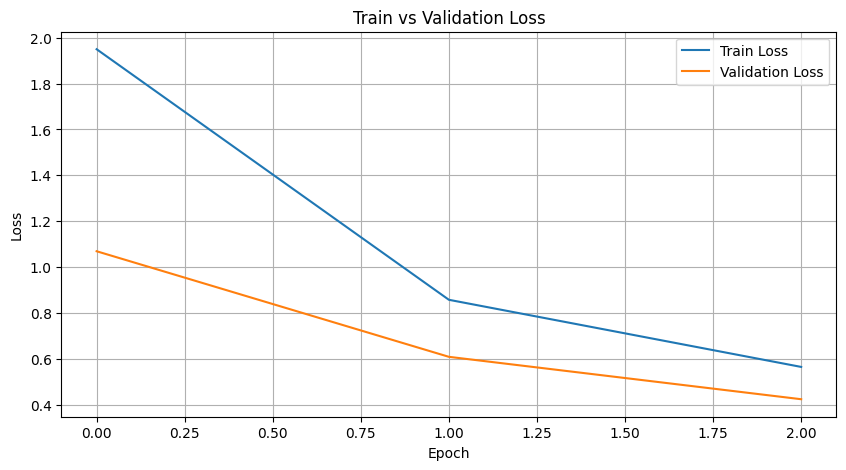

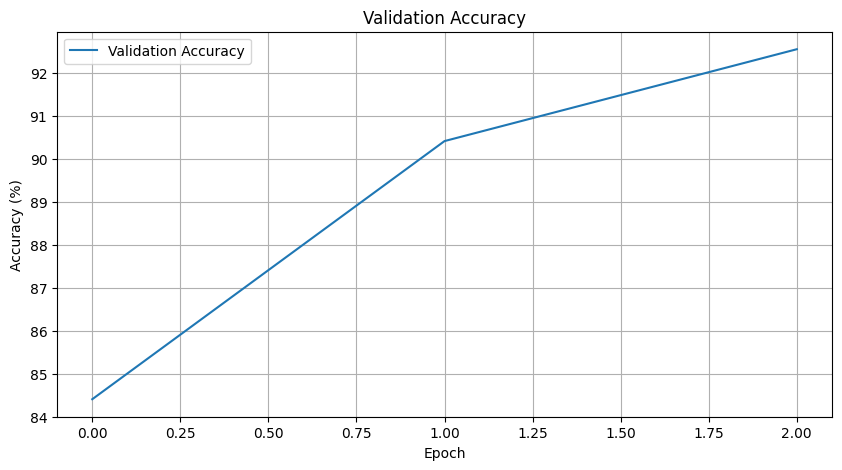

In [13]:
import matplotlib.pyplot as plt

# -------------------------
# Loss Train vs Val
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

# -------------------------
# Accuracy de Validación
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()


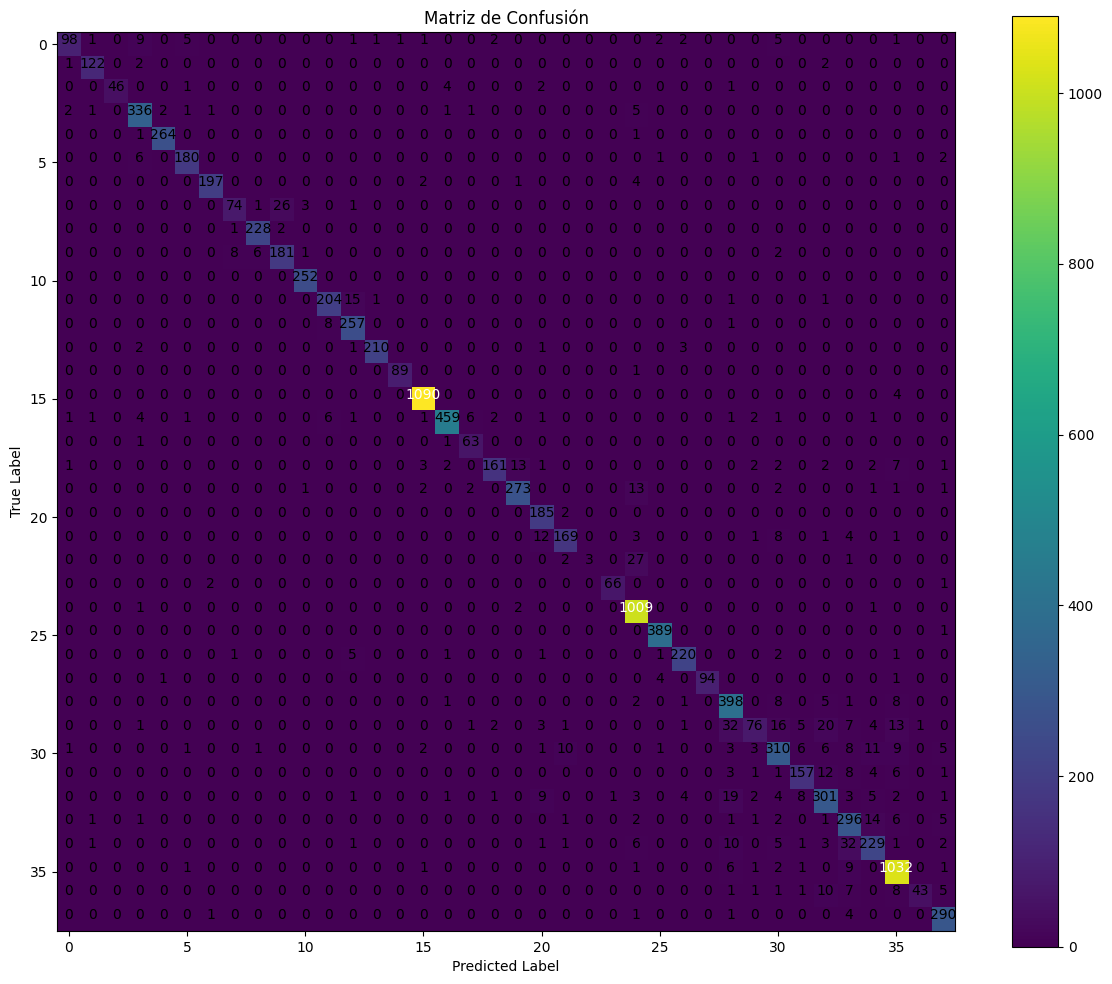

In [14]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1) Obtener predicciones del modelo en el loader de validación/test
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2) Crear matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# 3) Graficar
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusión")
plt.colorbar()

# Opcional: mostrar números
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
